[Load data](#load)

[Formulate prediction problem](#problem)

[Exploration](#explore)

[Simple classifier](#simple_classifier)

[Load cleaned training data](#load_clean)

In [1]:
# Data tools
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ML tools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor

## Load raw data
<a id='load'></a>

In [2]:
data = pd.read_csv('building-permit-applications-data/Building_Permits.csv')
nrows, ncols = data.shape
print(f"Original dataset has {nrows} rows and {ncols} columns")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original dataset has 198900 rows and 43 columns


In [3]:
print("Column names:\n")
for col in data.columns:
    print(col)

Column names:

Permit Number
Permit Type
Permit Type Definition
Permit Creation Date
Block
Lot
Street Number
Street Number Suffix
Street Name
Street Suffix
Unit
Unit Suffix
Description
Current Status
Current Status Date
Filed Date
Issued Date
Completed Date
First Construction Document Date
Structural Notification
Number of Existing Stories
Number of Proposed Stories
Voluntary Soft-Story Retrofit
Fire Only Permit
Permit Expiration Date
Estimated Cost
Revised Cost
Existing Use
Existing Units
Proposed Use
Proposed Units
Plansets
TIDF Compliance
Existing Construction Type
Existing Construction Type Description
Proposed Construction Type
Proposed Construction Type Description
Site Permit
Supervisor District
Neighborhoods - Analysis Boundaries
Zipcode
Location
Record ID


## Formulate prediction problem
<a id='problem'></a>

A permit is first filed, then issued, and finally construction is completed. 

In [5]:
percent_filed     = 100*(nrows - sum((data['Filed Date']).isna()))/nrows
percent_issued    = 100*(nrows - sum((data['Issued Date']).isna()))/nrows
percent_completed = 100*(nrows - sum((data['Completed Date']).isna()))/nrows

print(f"{np.round(percent_filed, 2)}% of all permits have been filed")
print(f"{np.round(percent_issued, 2)}% of all permits have been issued")
print(f"{np.round(percent_completed, 2)}% of all permits have completed construction")

100.0% of all permits have been filed
92.49% of all permits have been issued
48.86% of all permits have completed construction


A regression problem would be to predict the time it takes for a permit to be issued since the day it was filed. 
However, the above output shows that not every permit has been issued. Simply removing unissued permits from our dataset would result in a sampling bias against them. This is significant because we can expect about 1 - 0.925 = 7.5% of all out-of-sample permits to not be issued. 

To remedy this, we can build two models that occur in sequence:
1. Classify whether or not a permit will be issued by training on both issued and unissued permit data. 
2. Predict the number of days it will take for a permit to be issued by training on permits that we know were eventually issued. 

i.e. for a new (test) permit, first classify whether or not it will eventually be issued (not based on the date it was filed). If it will be issued, then predict the number of days that will take. 

Now let's code the relevant date features as the number of days since the oldest permit date, create the labels needed for each of these tasks, and add them to our dataset. 

In [17]:
min_date = pd.to_datetime("01/01/2013") # source: Kaggle page

"""
Returns a column where each date string in `date_col` is the
number of days since January 1st, 2013. 
"""
def convert_date(date_col):
    timestamps = pd.to_datetime(date_col)
    days_since = timestamps - min_date
    return days_since.dt.days

In [12]:
data['Filed Days'] = convert_date(data['Filed Date'])
data['Issued Days'] = convert_date(data['Issued Date'])

# labels
data['Issued or not'] = 1 - (data['Issued Date']).isna() # 1 = permit was eventually issued
data['Days to issue'] = data['Issued Days'] - data['Filed Days']

Store the issued permits for our regression task in ``data_issued``. 

In [13]:
data_issued = data[(data['Issued or not'] == 1)]
nrows_issued, ncols_issued = data_issued.shape

print(f"Regression dataset has {nrows_issued} rows and {ncols_issued} columns")

Regression dataset has 183960 rows and 49 columns


## Exploration
<a id='explore'></a>

In [ ]:
data_sample = data_issued.sample(n=10000)
plt.xlabel("Date filed")
plt.ylabel("Days to issue")
plt.scatter(pd.to_datetime(data_sample['Filed Date']), data_sample['Days to issue']);

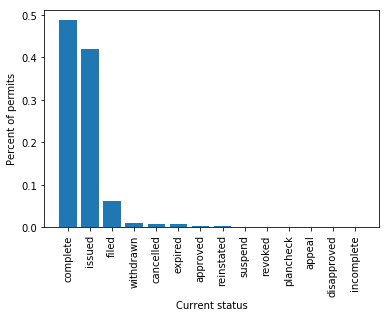

In [21]:
status_counter = Counter(data['Current Status'])
status_percent = {status:(count/nrows) for status,count in status_counter.items()}
status_percent = dict(sorted(status_percent.items(), key=lambda kv: kv[1], reverse=True))

plt.xticks(rotation='vertical')
plt.xlabel("Current status")
plt.ylabel("Percent of permits")
plt.bar(status_percent.keys(), status_percent.values());

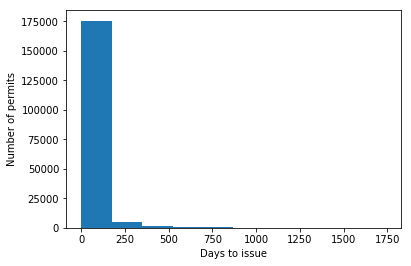

In [14]:
plt.xlabel("Days to issue")
plt.ylabel("Number of permits")
plt.hist(data_issued['Days to issue']);

In [15]:
percent_same_day = 100*sum(data_issued['Days to issue'] == 0) / nrows_issued
print(f"{np.round(percent_same_day, 2)}% of all issued permits were issued the same day they were filed")

62.78% of all issued permits were issued the same day they were filed


## Load cleaned training data
<a id='load_clean'></a>

In [2]:
data = pd.read_csv('data_train_clean1.csv')

In [3]:
n = 50000
data_sample = data.sample(n=n)

baseline = sum(data_sample['Issued or not'] == 1)/n
print(f"Baseline for classifier: {baseline}")

Baseline for classifier: 0.9243


In [5]:
permit_type = np.array(pd.get_dummies(data_sample['Permit Type']))

X = permit_type
print(X.shape)
y = np.array(data_sample['Issued or not'])

(50000, 8)


In [6]:
def svm(X, y):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
    clf = SVC(C=1.0, gamma='auto')
    clf.fit(X_tr, y_tr)

    train_acc = clf.score(X_tr, y_tr) 
    test_acc  = clf.score(X_te, y_te)
    print(f"Training accuracy = {train_acc}")
    print(f"Test accuracy     = {test_acc}")
    return clf
    
clf = svm(X, y)

Training accuracy = 0.924025
Test accuracy     = 0.9261


## Scatterplots

Text(0, 0.5, 'Days to issue')

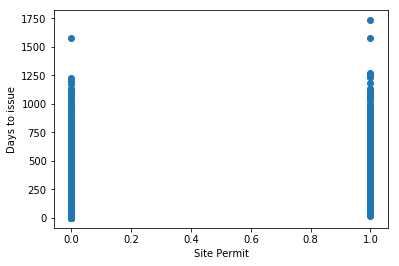

In [7]:
plt.scatter(data_sample['Site Permit'], data_sample['Days to issue'])
plt.xlabel("Site Permit")
plt.ylabel("Days to issue")

Text(0, 0.5, 'Days to issue')

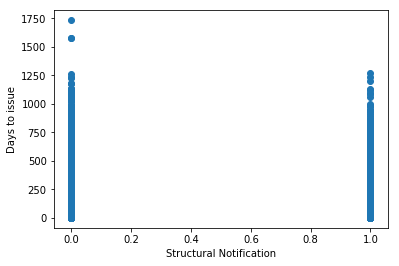

In [8]:
plt.scatter(data_sample['Structural Notification'], data_sample['Days to issue'])
plt.xlabel("Structural Notification")
plt.ylabel("Days to issue")

Text(0, 0.5, 'Days to issue')

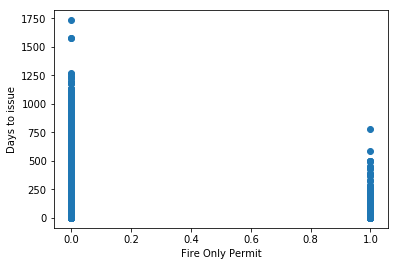

In [9]:
plt.scatter(data_sample['Fire Only Permit'], data_sample['Days to issue'])
plt.xlabel("Fire Only Permit")
plt.ylabel("Days to issue")

Text(0, 0.5, 'Days to issue')

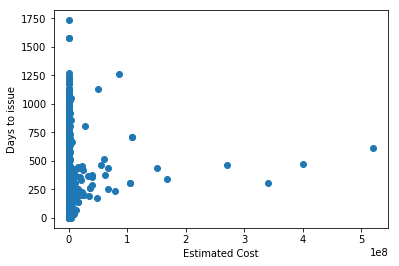

In [10]:
plt.scatter(data_sample['Estimated Cost'], data_sample['Days to issue'])
plt.xlabel("Estimated Cost")
plt.ylabel("Days to issue")

Text(0, 0.5, 'Days to issue')

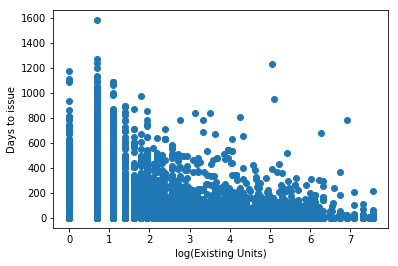

In [11]:
plt.scatter(np.log(data_sample['Existing Units']+1), data_sample['Days to issue'])
plt.xlabel("log(Existing Units)")
plt.ylabel("Days to issue")

Text(0, 0.5, 'Days to issue')

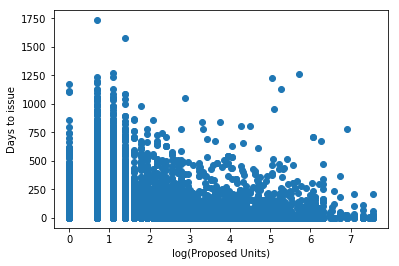

In [12]:
plt.scatter(np.log(data_sample['Proposed Units']+1), data_sample['Days to issue'])
plt.xlabel("log(Proposed Units)")
plt.ylabel("Days to issue")

Text(0, 0.5, 'Days to issue')

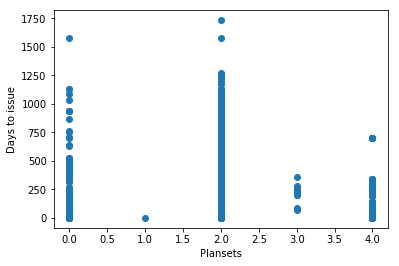

In [13]:
plt.scatter(data_sample['Plansets'], data_sample['Days to issue'])
plt.xlabel("Plansets")
plt.ylabel("Days to issue")

Text(0, 0.5, 'Days to issue')

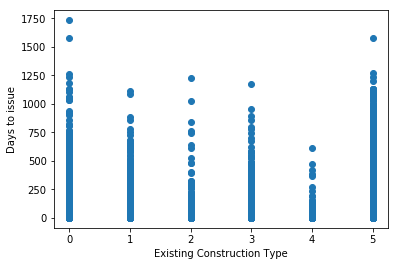

In [14]:
plt.scatter(data_sample['Existing Construction Type'], data_sample['Days to issue'])
plt.xlabel("Existing Construction Type")
plt.ylabel("Days to issue")

Text(0, 0.5, 'Days to issue')

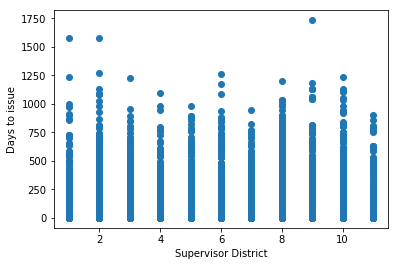

In [15]:
plt.scatter(data_sample['Supervisor District'], data_sample['Days to issue'])
plt.xlabel("Supervisor District")
plt.ylabel("Days to issue")

Text(0, 0.5, 'Days to issue')

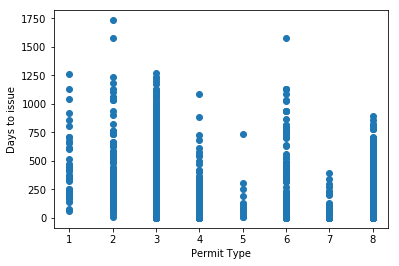

In [16]:
plt.scatter(data_sample['Permit Type'], data_sample['Days to issue'])
plt.xlabel("Permit Type")
plt.ylabel("Days to issue")

## Regression

In [19]:
# remove missing values
data_sample = data_sample[(data_sample['Days to issue'].isna() == False)]
data_sample = data_sample[(data_sample['Fire Only Permit'].isna() == False)]
data_sample = data_sample[(data_sample['Plansets'].isna() == False)]
data_sample = data_sample[(data_sample['Existing Units'].isna() == False)]

# encode data
permit_type = np.array(pd.get_dummies(data_sample['Permit Type']))
fire = np.array(data_sample['Fire Only Permit'])
plansets = np.array(data_sample['Plansets'])
units = np.array(data_sample['Existing Units'])

# form features and labels, split
X = np.column_stack((permit_type, fire, plansets, units))
y = np.array(data_sample['Days to issue'])
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

print(X_tr.shape)
print(X_te.shape)

(27236, 7)
(6809, 7)


In [20]:
# run model
regr = RandomForestRegressor(max_depth=5)
regr.fit(X_tr, y_tr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
# R^2
regr.score(X_tr, y_tr)

0.5109841961098316

In [22]:
# RMSE training
n, _ = X_tr.shape
y_pred = np.maximum(regr.predict(X_tr), 0)
MSE = 1/n*np.sum((y_tr - y_pred)**2)
RMSE = MSE**0.5
print(RMSE)

64.26448479733769


In [23]:
# RMSE test
n, _ = X_te.shape
y_pred = np.maximum(regr.predict(X_te), 0)
MSE = 1/n*np.sum((y_te - y_pred)**2)
RMSE = MSE**0.5
print(RMSE)

68.4292185240694


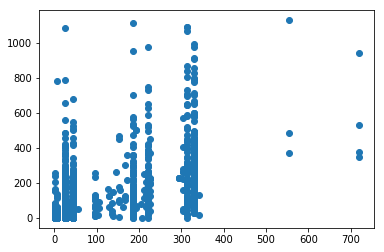

In [24]:
# where is underfitting? everywhere
plt.scatter(y_pred, y_te)

## Classify 0-day permits

In [58]:
# what percent are 0's for this sample?
sum(y == 0)/len(y)

0.5569393449845792

In [26]:
y_bin = y.copy()
y_bin[y_bin > 0] = 1

In [27]:
Counter(y_bin)

Counter({0.0: 18961, 1.0: 15084})

In [28]:
# 0's are predictable
clf = svm(X, y_bin)

Training accuracy = 0.8566970186517844
Test accuracy     = 0.8518137758848583


In [33]:
nonzero_data_bools = (clf.predict(X) == 1)
nonzero_data_indices = [i for i,x in enumerate(nonzero_data_bools) if x]

In [34]:
len(nonzero_data_indices)

15424

In [36]:
X_nonzero = X[nonzero_data_indices, :]
y_nonzero = y[nonzero_data_indices]

In [38]:
X_nonzero_tr, X_nonzero_te, y_nonzero_tr, y_nonzero_te = train_test_split(X_nonzero, y_nonzero, test_size=0.2)

In [52]:
regr = RandomForestRegressor(max_depth=5)
regr.fit(X_nonzero_tr, y_nonzero_tr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [53]:
regr.score(X_nonzero_tr, y_nonzero_tr)

0.45674248410680895

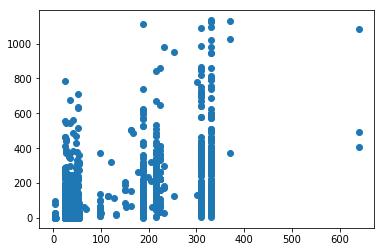

In [54]:
plt.scatter(regr.predict(X_nonzero_te), y_nonzero_te)

In [59]:
# RMSE training
n, _ = X_nonzero_tr.shape
y_nonzero_pred = np.maximum(regr.predict(X_nonzero_tr), 0)
MSE = 1/n*np.sum((y_nonzero_tr - y_nonzero_pred)**2)
RMSE = MSE**0.5
print(RMSE)

93.09604766455415


In [60]:
# RMSE test
n, _ = X_nonzero_te.shape
y_nonzero_pred = np.maximum(regr.predict(X_nonzero_te), 0)
MSE = 1/n*np.sum((y_nonzero_te - y_nonzero_pred)**2)
RMSE = MSE**0.5
print(RMSE)

104.35074263858421


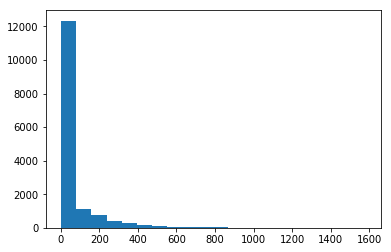

In [63]:
plt.hist(y_nonzero, bins=20);

In [64]:
np.mean(y_nonzero)

62.41967064315353

In [66]:
np.var(y_nonzero)**.5

129.67781964619192

In [69]:
nonzero = np.column_stack((X_nonzero, y_nonzero))
np.savetxt("nonzero.csv", nonzero, delimiter=",")